In [1]:
# importing the packages
using POMDPs
using POMDPTools # Tools to define MDP, e.g., SparseCat, stepthrough
using Plots; default(fontfamily="Computer Modern", framestyle=:box)
using Plots.PlotMeasures
using DiscreteValueIteration 
using CSV, DataFrames 
using ArgParse
using MCTS

In [2]:
# define the arguments
function parse_commandline()
    arg = ArgParseSettings()

    @add_arg_table arg begin
        "--name" 
            help="output file name's id" 
            arg_type=String
            default="1"
        "--discount_factor" 
            help="discount factor" 
            arg_type=Float64
            default=0.95
        "--max_steps" 
            help="max steps" 
            arg_type=Int
            default=32
    end
    return parse_args(arg)
end

# parse the arguments
parsed_args = parse_commandline()

Dict{String, Any} with 3 entries:
  "max_steps"       => 32
  "name"            => "1"
  "discount_factor" => 0.95

In [3]:
# human and robot are at an intersection (stop signs)
# they both start stopped (i.e., at position = 0)
# the game resets after one agent goes (i.e., at position = 1)

# this the global variable for eveything
# stores the most recent human action
human_action = nothing # noting is line None in Python

# define the state type
mutable struct mdpState
    hums::Int # human position
    robs::Int # robot position
    z::Int
    phi::Int
end;

#return probability of action = "stop"
function human_policy(hums, robs,  z)
    # workaround for the case where s = (0, 0)
    # Do we need this workaround?
    if hums != 0 || robs !=0 
        return 0.5
    end
    # z = 0 is a defensive human
    if z == 0
        return 0.9
    else
    # z = 1 is an aggressive human        
        return 0.1
    end
end;

# return updated z
function human_dynamics(hums, robs, z, phi)
    # phi = 0 is a human who never changes z
    if phi == 0
        return z
    # phi = 1 is a human who changes
    else
        # if a collision occurs
        if hums == 1 && robs == 1
            return 0
        else
            return z
        end
    end
end;

mutable struct simpleWorld <: MDP{mdpState, Symbol}
    discount_factor::Float64
end;

# constructor for convenience
function simpleWorld(;discount_factor::Float64=0.95)
    return simpleWorld(discount_factor)
end;

# define the state space
function POMDPs.states(mdp::simpleWorld)
    s = mdpState[] # empty array of states
    # loop over all possible states
    for hums = 0:1, robs = 0:1, z = 0:1, phi = 0:1
        push!(s, mdpState(hums, robs, z, phi))
    end
    return s
end;

In [4]:
# define the action space
POMDPs.actions(mdp::simpleWorld) = [:stop, :go] # actions symbols/strings

# define the transition function
function POMDPs.transition(mdp::simpleWorld, state::mdpState, action::Symbol)
    hums, robs, z, phi = state.hums, state.robs, state.z, state.phi
    a = action
    p_stop = human_policy(hums, robs, z)
    z1 = human_dynamics(hums, robs, z, phi)
    
    # reset
    if hums > 0 || robs > 0
        return Deterministic(mdpState(0,0,z1,phi))
    end

    # move robot car
    # becaue of s1 we need a mutable struct for state
    s1 = mdpState(hums, robs, z1, phi)
    if a == :go
        s1.robs += 1
    end

    # move human car
    global human_action
    if rand() < p_stop
        human_action = :stop
        return Deterministic(s1)
    else
        s1.hums += 1
        human_action = :go
        return Deterministic(s1)
    end
end;

# define the reward function
function POMDPs.reward(mdp::simpleWorld, state::mdpState, action::Symbol)
    hums = state.hums
    robs = state.robs
    # no one goes
    if hums == 0 && robs == 0
        return 0
    end
    # human goes through first
    if hums == 1 && robs == 0
        return -3
    end
    # both go and we crash
    if hums == 1 && robs == 1
        return -10
    end
    # robot goes through first
    if hums == 0 && robs == 1
        return +5
    end
end;

# MISC functions
POMDPs.discount(mdp::simpleWorld) = mdp.discount_factor
# Indexing functions
function POMDPs.stateindex(mdp::simpleWorld, s::mdpState)
    hums = s.hums
    robs = s.robs
    z = s.z
    phi = s.phi
    # state is a number between 1 and 16
    return hums + 2*robs + 4*z + 8*phi + 1 
end;

function POMDPs.actionindex(mdp::simpleWorld, a::Symbol)
    # this says that the action is a number between 1 and 2
    # 1 is stop and 2 is go, why 1? becasue julia is 1 indexed
    return a == :stop ? 1 : 2 
end

# human is initially aggressive, not sure if phi = 0 or 1
# if phi = 0 then we cannot change z
# if phi = 1 then we can make human defensive by crashing


In [5]:
# Initialize an array to store the cumulative rewards for each run
cum_rwd_runs = Array{Array{Int,1},1}()
crossings_first_50 = 0
crossings_last_50 = 0
rest_first_50 = 0
rest_last_50 = 0
collisions_first_50 = 0
collisions_last_50 = 0
yieldings_first_50 = 0
yieldings_last_50 = 0


for iteration in 1:100
    POMDPs.initialstate(mdp::simpleWorld) = rand([Deterministic(mdpState(0, 0, 1, 0)),Deterministic(mdpState(0, 0, 1, 1))])
    # definition is done, lets solve it
    mdp = simpleWorld()
    #solver = ValueIterationSolver(max_iterations=200)
    solver = MCTSSolver(n_iterations=50, depth=20, exploration_constant=5.0)
    policy = solve(solver, mdp) 

    human_pos = []
    robot_pos = []
    human_phi = []
    human_z = []
    reward = []


    # run the simulation
    for (s,a,r) in stepthrough(mdp, policy, "s,a,r", max_steps=parsed_args["max_steps"])
        push!(human_pos, s.hums)
        push!(robot_pos, s.robs)
        push!(human_z, s.z)
        push!(human_phi, s.phi)
        push!(reward, r)
        # push!(reward, POMDPs.reward(pomdp, s, a))
        if s.hums > s.robs
            if iteration <= 50
                crossings_first_50 += 1
            else
                crossings_last_50 += 1
            end
        elseif s.hums == s.robs && s.robs == 1
            if iteration <= 50
                collisions_first_50 += 1
            else
                collisions_last_50 += 1
            end
        elseif s.hums == s.robs && s.robs == 0
            if iteration <= 50
                rest_first_50 += 1
            else
                rest_last_50 += 1
            end
        else
            if iteration <= 50
                yieldings_first_50 += 1
            else
                yieldings_last_50 += 1
            end
        end
    end
    ## Append cum_rwd to the runs array
    cum_rwd =cumsum(reward)
    push!(cum_rwd_runs, cum_rwd)
end

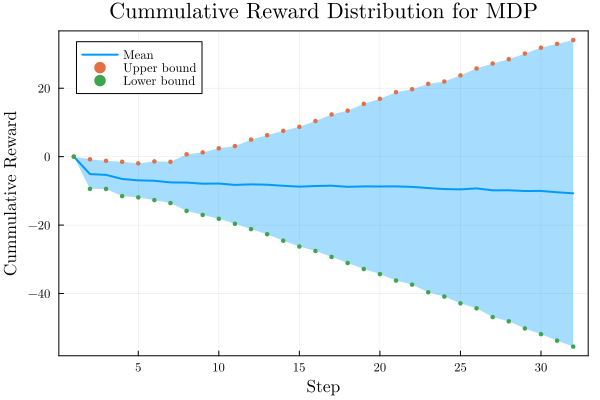

In [6]:
max_length = maximum(length.(cum_rwd_runs))
averages = zeros(max_length)
counts = zeros(Int, max_length)
sum_of_squares = zeros(max_length) # To store the sum of squared differences

for run in cum_rwd_runs
    for (index, value) in enumerate(run)
        averages[index] += value
        counts[index] += 1
    end
end

averages ./= counts

# Calculate sum of squared differences
for run in cum_rwd_runs
    for (index, value) in enumerate(run)
        sum_of_squares[index] += (value - averages[index])^2
    end
end

# Calculate standard deviation
std_devs = sqrt.(sum_of_squares ./ counts)

y1 = averages + std_devs
y2 = averages - std_devs


plot(averages, ribbon = std_devs , fillalpha = 0.35, c = 1, lw = 2, title="Cummulative Reward Distribution for MDP", xlabel="Step", ylabel="Cummulative Reward", legend = :topleft, label = "Mean")
plot!(y1, line = :scatter, msw = 0, ms = 2.5, label = "Upper bound")
plot!(y2, line = :scatter, msw = 0, ms = 2.5, label = "Lower bound")

In [7]:
averages

32-element Vector{Float64}:
   0.0
  -5.09
  -5.33
  -6.52
  -6.93
  -7.04
  -7.53
  -7.58
  -7.9
  -7.86
   ⋮
  -9.47
  -9.56
  -9.28
  -9.84
  -9.83
 -10.04
 -10.02
 -10.41
 -10.72

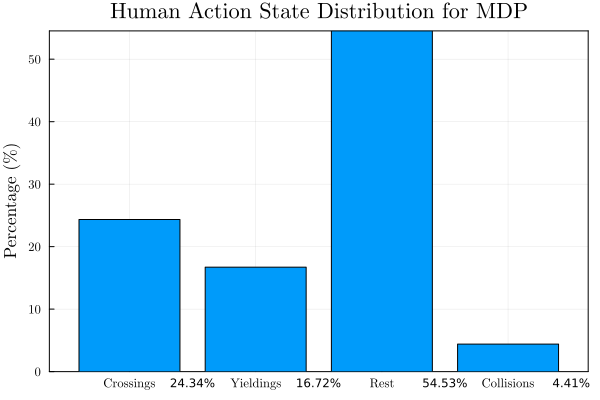

In [8]:
# Calculate totals for first 50 and last 50 iterations
total_crossings = crossings_first_50 + crossings_last_50
total_yieldings = yieldings_first_50 + yieldings_last_50
total_rest = rest_first_50 + rest_last_50
total_collisions = collisions_first_50 + collisions_last_50

# Calculate total events
total_events = total_crossings + total_yieldings + total_rest + total_collisions

# Calculate percentages
percent_crossings = (total_crossings / total_events) * 100
percent_yieldings = (total_yieldings / total_events) * 100
percent_rest = (total_rest / total_events) * 100
percent_collisions = (total_collisions / total_events) * 100

# Data for bar chart
categories = ["Crossings", "Yieldings", "Rest", "Collisions"]
percentages = [percent_crossings, percent_yieldings, percent_rest, percent_collisions]

# Plot
p = bar(categories, percentages, title="Human Action State Distribution for MDP", ylabel="Percentage (%)", legend=false)

y_offset = -1.8  # Adjust this offset if needed
for (i, pct) in enumerate(percentages)
    annotate!(p, [i], [y_offset], text(string(round(pct, digits=2)) * "%", :center, 8))  # Adjusting text position and size
end

# Display the plot
display(p)

In [9]:
# ########### Plotting ############
# # nice function!
# cum_reward = cumsum(reward)
# # print("Reward: ", reward)
# # println("")
# # print("Cum Reward: ", cum_reward)

# function plot_results(human_pos, robot_pos, cum_reward, human_z, human_phi)
#     p1 = plot(human_pos, color=:green, legend = false,
#         xlabel="time step", ylabel="position", 
#         title="Human", 
#         marker=:circle, linestyle=:solid)
#     p2 = plot(robot_pos, color=:darkkhaki, legend = false,
#         xlabel="time step", ylabel="position", 
#         title="Robot", 
#         marker=:circle, linestyle=:solid)
#     p3 = plot(cum_reward, color=:blue, legend = false,
#         xlabel="time step", ylabel="reward", 
#         title="Cumulative Reward", 
#         marker=:circle, linestyle=:solid)
#     p4 = plot(human_z, color=:red, legend = false,
#         xlabel="time step", ylabel="z",
#         title="z" , ylims=(-0.2,1.2),
#         marker=:circle, linestyle=:solid)
#     # show human_phi
#     annotate!(p4, [(1, -0.6, "phi = " * string(human_phi[1]))])
#     plot(p1, p2, p3, p4, layout=(4,1), size=(600,800))
#     display(plot(p1, p2, p3, p4, layout=(4,1), size=(600,800), show = true))
#     # gui()
# end;

# plot_results(human_pos, robot_pos, cum_reward, human_z, human_phi)